### Importing important libraries

In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, PhaseEstimation
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

### Useful functions

In [3]:
def function_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

# Convert the sequence to a binary string
def convert_to_binary_string(sequence, charac):
    """
    Convert a sequence of characters from {a, b, c, d} to a binary string.
    Replace 'charac' with '1' and all other characters with '0'.

    Parameters:
        sequence (str): Input sequence of characters.
        charac (str): Character to be replaced with '1'.

    Returns:
        str: Binary string with '1' for 'charac' and '0' for other characters.
    """
    binary_string = ''.join(['1' if char == charac else '0' for char in sequence])
    return binary_string

In [4]:
import numpy as np

# Define the alphabet and their corresponding probabilities
alphabet = ['a', 'b', 'c', 'd']
probabilities = [0.2, 0.3, 0.1, 0.4]

# Define the length of the sequence
N = 10  # Example length, you can change this to any desired length

# Generate the sequence
sequence = np.random.choice(alphabet, size=N, p=probabilities)

# Join the sequence
sequence = ''.join(sequence)

binary_string = convert_to_binary_string(sequence, 'a')

# Find the locations of '1' in the binary string and convert to binary representation
marked_states = [format(index, f'0{len(bin(N-1)[2:])}b') for index, char in enumerate(binary_string) if char == '1']

print("Original sequence:", sequence)
print("Binary string:", binary_string)
print("Marked states (locations of '1'):", marked_states)

Original sequence: dcadaadbdb
Binary string: 0010110000
Marked states (locations of '1'): ['0010', '0100', '0101']


In [5]:
epsilon=0.4

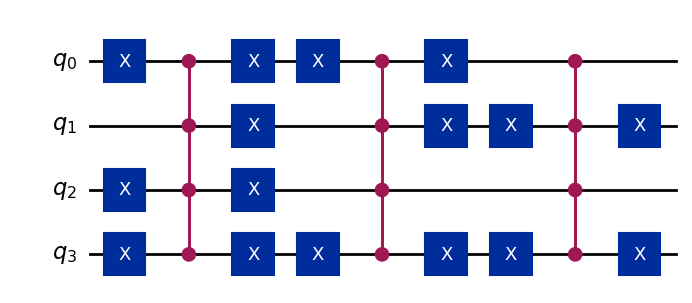

In [6]:
oracle = function_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

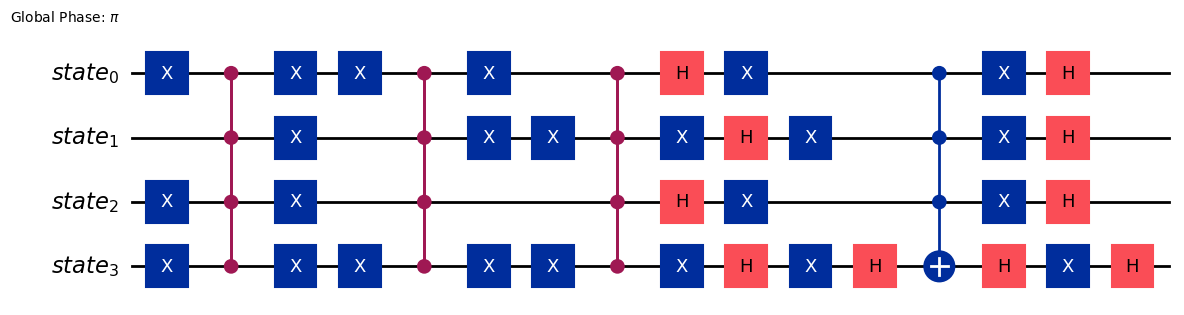

In [7]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [8]:
num_evaluation_qubits = grover_op.num_qubits + math.ceil(math.log2(2+(1/2*epsilon)))

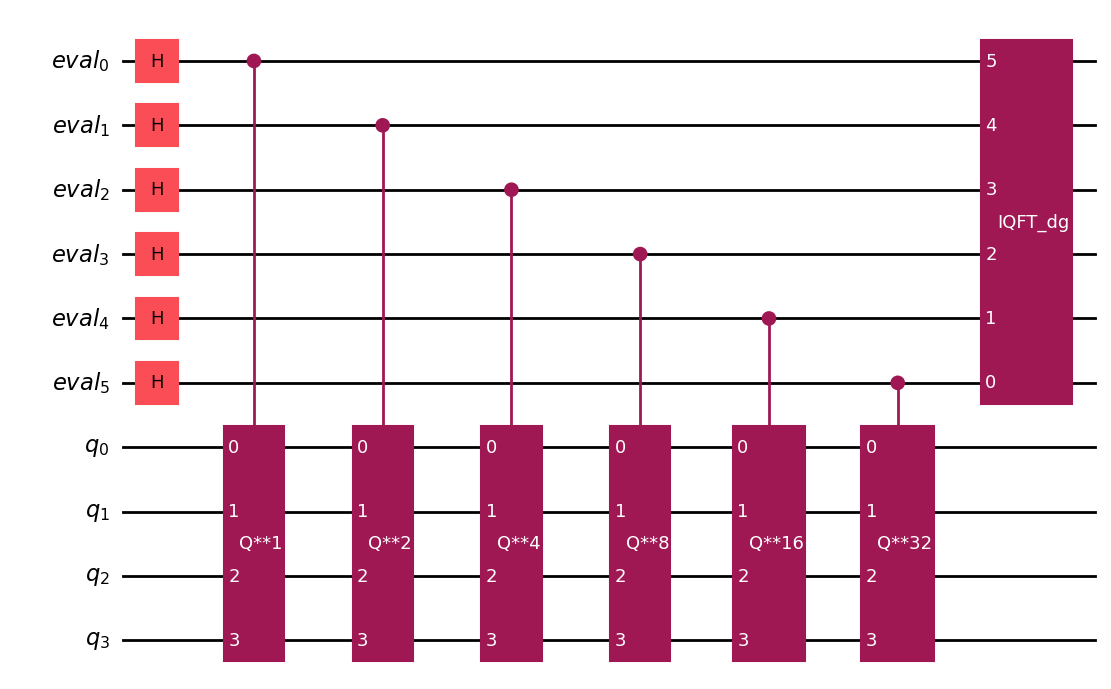

In [9]:
PhaseEstimation(num_evaluation_qubits, unitary=grover_op).decompose().draw(output="mpl", style="iqp")

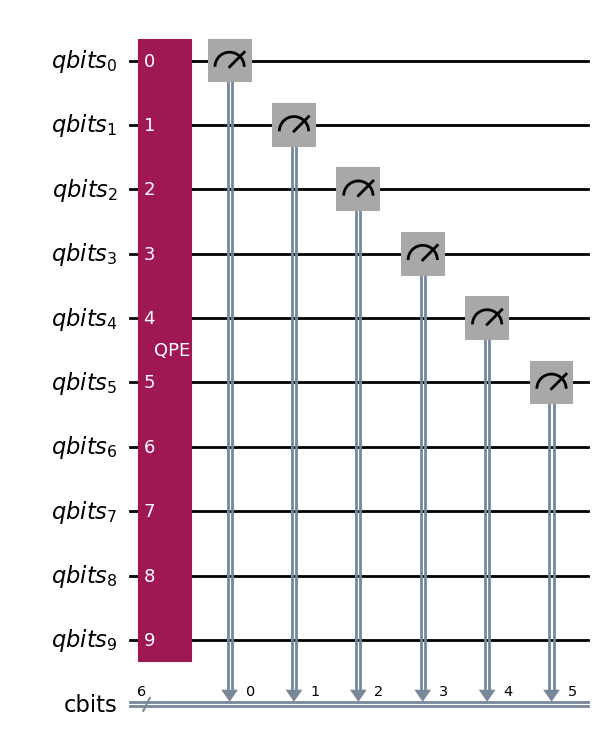

In [10]:
qbits = QuantumRegister(num_evaluation_qubits+grover_op.num_qubits,name='qbits')
cbits = ClassicalRegister(num_evaluation_qubits,name='cbits')
qc = QuantumCircuit(qbits,cbits,name='qc')
qc.compose(PhaseEstimation(num_evaluation_qubits, unitary=grover_op), inplace=True)
qc.measure(range(num_evaluation_qubits), range(num_evaluation_qubits))
qc.draw(output="mpl", style="iqp")

In [11]:
backend = AerSimulator()
target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

ValueError: Image size of 2263x725359 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2263.44x725360 with 1 Axes>

In [15]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.cbits.get_counts()

C:\Users\nihar\AppData\Local\Temp\ipykernel_23944\2487417585.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


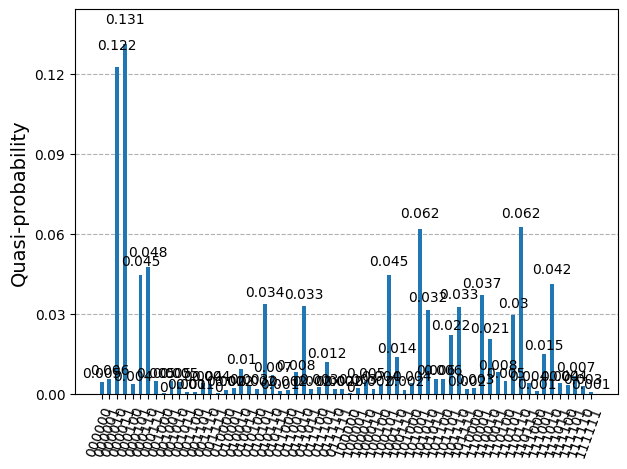

In [16]:
plot_distribution(dist)

In [18]:
# Find the maximum value in the distribution
max_key = max(dist, key=dist.get)
max_key


'000011'